# Airbnb in London 2024


## The Problem Statement:
<b> This project aims to develop a data-driven pricing model for Airbnb listings in London (2024) by analyzing key factors influencing price, with the goal of improving pricing accuracy by at least 15% within 3 months to help hosts maximize revenue and occupancy. </b>

#### The analysing issues:
<ul>
    <li> Data Quality Issues (missing values, outliers); </li>
    <li> Factors influencing pricing; </li>
    <li> Model Performance and Predictive Accuracy. </li>
</ul>

### Importing Python libraries

In [1]:
!pip install geopandas folium
!pip install shapely fiona pyproj rtree
!pip install geopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Importing the dataset

In [4]:
airbnb_df = pd.read_csv('listings2024.csv')
print(airbnb_df.info())
airbnb_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95144 entries, 0 to 95143
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              95144 non-null  int64  
 1   name                            95144 non-null  object 
 2   host_id                         95144 non-null  int64  
 3   host_name                       95137 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   95144 non-null  object 
 6   latitude                        95144 non-null  float64
 7   longitude                       95144 non-null  float64
 8   room_type                       95144 non-null  object 
 9   price                           62777 non-null  float64
 10  minimum_nights                  95144 non-null  int64  
 11  number_of_reviews               95144 non-null  int64  
 12  last_review                     

id                                              name  host_id host_name  \
0  13913               Holiday London DB Room Let-on going    54730     Alina   
1  15400               Bright Chelsea  Apartment. Chelsea!    60302  Philippa   
2  17402  Very Central Modern 3-Bed/2 Bath By Oxford St W1    67564       Liz   
3  24328                  Battersea live/work artist house    41759       Joe   
4  31036    Bright  compact 1 Bedroom Apartment Brick Lane   133271  Hendryks   

   neighbourhood_group           neighbourhood  latitude  longitude  \
0                  NaN               Islington  51.56861   -0.11270   
1                  NaN  Kensington and Chelsea  51.48811   -0.16878   
2                  NaN             Westminster  51.52195   -0.14094   
3                  NaN              Wandsworth  51.47072   -0.16266   
4                  NaN           Tower Hamlets  51.52425   -0.06997   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room   59.0               1                 47  2024-11-17   
1  Entire home/apt  120.0               4                 96  2024-04-28   
2  Entire home/apt  501.0               3                 56  2024-02-19   
3  Entire home/apt  225.0               2                 94  2022-07-19   
4  Entire home/apt  105.0               3                123  2024-01-05   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.27                               3               344   
1               0.53                               1                85   
2               0.33                               6               297   
3               0.55                               1               284   
4               0.70                               8               346   

   number_of_reviews_ltm  license  
0                      6      NaN  
1                      2      NaN  
2                      1      NaN  
3                      0      NaN  
4                      2      NaN

### Data Cleansing

Since the dataset contains two features (<b> 'neighbourhood_group' </b> and <b> 'license'</b>) with only NULL values, it will be removed from the dataframe. The missing values of <b>'price'</b> column will be filled with <b>the median</b>.

In [7]:
new_df = airbnb_df.dropna(axis = 1, how = 'all') # Removing columns that contain only NaN values
median_price = new_df.loc[:, 'price'].median() # Define the median of the variable
new_df.loc[:, 'price'] = new_df.loc[:, 'price'].fillna(median_price) # Fill missing 'price' values with the median
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95144 entries, 0 to 95143
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              95144 non-null  int64  
 1   name                            95144 non-null  object 
 2   host_id                         95144 non-null  int64  
 3   host_name                       95137 non-null  object 
 4   neighbourhood                   95144 non-null  object 
 5   latitude                        95144 non-null  float64
 6   longitude                       95144 non-null  float64
 7   room_type                       95144 non-null  object 
 8   price                           95144 non-null  float64
 9   minimum_nights                  95144 non-null  int64  
 10  number_of_reviews               95144 non-null  int64  
 11  last_review                     70560 non-null  object 
 12  reviews_per_month               

The column <b> 'reviews_per_month' </b> has missing values. Before filling them, we check its skewness to decide whether to use the median or mean.

3.253569472143798


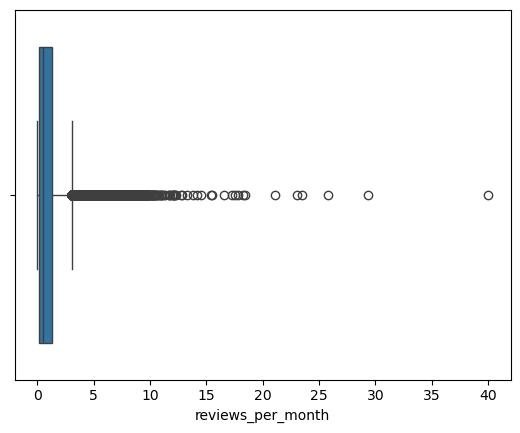

In [11]:
print(new_df['reviews_per_month'].skew()) # Check skewness of 'reviews_per_month' (has missing values) 
sns.boxplot(x = new_df['reviews_per_month']) # Visualize distribution to assess outliers before handling missing data
plt.show()

Since the 'reviews_per_month' column is skewed and contains many outliers, I fill the missing values with <b> the median </b>.

In [14]:
median = new_df.loc[:, 'reviews_per_month'].median() # Define the median of the variable
new_df.loc[:, 'reviews_per_month'] = new_df.loc[:, 'reviews_per_month'].fillna(median) # Fill missing 'reviews_per_month' values with the median
print(new_df.isnull().sum())  # To see missing values in all columns

id                                    0
name                                  0
host_id                               0
host_name                             7
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       24584
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
dtype: int64


Next, there are still columns with NULL values left: <b> 'last_review' and 'host_name'</b>. The 'last_review' column needs to be transformed to datetime type and from this variable I create a new column - <b> 'days_since_last_review' </b> since it is more relevant to the analysis.

In [17]:
new_df['last_review'] = pd.to_datetime(new_df['last_review']) # Convert 'last_review' to datetime
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95144 entries, 0 to 95143
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              95144 non-null  int64         
 1   name                            95144 non-null  object        
 2   host_id                         95144 non-null  int64         
 3   host_name                       95137 non-null  object        
 4   neighbourhood                   95144 non-null  object        
 5   latitude                        95144 non-null  float64       
 6   longitude                       95144 non-null  float64       
 7   room_type                       95144 non-null  object        
 8   price                           95144 non-null  float64       
 9   minimum_nights                  95144 non-null  int64         
 10  number_of_reviews               95144 non-null  int64         
 11  la

C:\Users\tasha\AppData\Local\Temp\ipykernel_11640\915415140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['last_review'] = pd.to_datetime(new_df['last_review']) # Convert 'last_review' to datetime


In [19]:
new_df.loc[:, 'days_since_last_review'] = (pd.to_datetime('today') - new_df.loc[:, 'last_review']).dt.days # Create a new column for days since the last review
new_df.loc[:, 'days_since_last_review'] = new_df.loc[:, 'days_since_last_review'].fillna(9999) # Fill missing values with 9999 (indicating no reviews)
new_df.loc[:, 'host_name'] = new_df.loc[:, 'host_name'].fillna('Unknown') # Fill missing 'host_name' values with 'Unknown'
airbnb = new_df.drop('last_review', axis = 1) # Drop 'last_review' column after extracting relevant info
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95144 entries, 0 to 95143
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              95144 non-null  int64  
 1   name                            95144 non-null  object 
 2   host_id                         95144 non-null  int64  
 3   host_name                       95144 non-null  object 
 4   neighbourhood                   95144 non-null  object 
 5   latitude                        95144 non-null  float64
 6   longitude                       95144 non-null  float64
 7   room_type                       95144 non-null  object 
 8   price                           95144 non-null  float64
 9   minimum_nights                  95144 non-null  int64  
 10  number_of_reviews               95144 non-null  int64  
 11  reviews_per_month               95144 non-null  float64
 12  calculated_host_listings_count  

C:\Users\tasha\AppData\Local\Temp\ipykernel_11640\903490490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[:, 'days_since_last_review'] = (pd.to_datetime('today') - new_df.loc[:, 'last_review']).dt.days # Create a new column for days since the last review


#### Detecting Outliers in Numerical Variables

Then, I check if the essential variable <b> 'price' </b> has many outliers and assess its skewness.

The skeweness of Price Variable is:  78.54503537705986


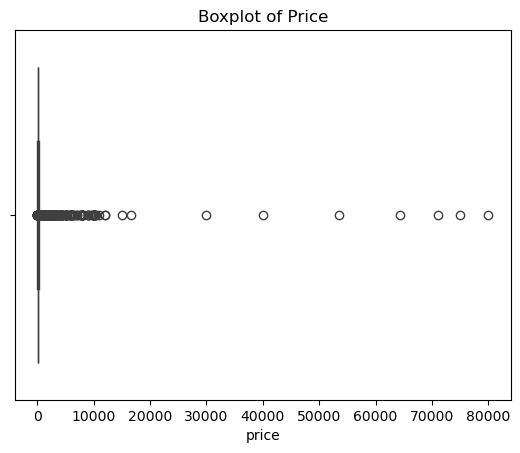

In [23]:
print("The skeweness of Price Variable is: ", airbnb['price'].skew()) # Print skewness of the 'price' variable
sns.boxplot(x = airbnb['price']) # Visualize distribution of 'price' with a boxplot to check for outliers
plt.title("Boxplot of Price")
plt.show()

The skewness of the <b> 'price' </b> variable is very high (78.54), and it contains many outliers. To clean the data, the price column will be transformed using <b> Winsorize transformation </b>.

Skewness after Winsorize transformation: 3.3166945818045446


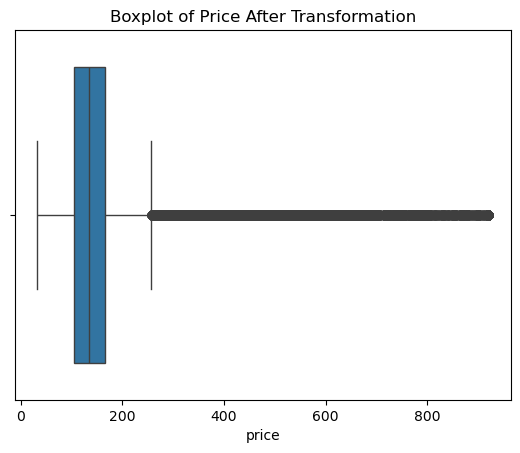

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95144 entries, 0 to 95143
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              95144 non-null  int64  
 1   name                            95144 non-null  object 
 2   host_id                         95144 non-null  int64  
 3   host_name                       95144 non-null  object 
 4   neighbourhood                   95144 non-null  object 
 5   latitude                        95144 non-null  float64
 6   longitude                       95144 non-null  float64
 7   room_type                       95144 non-null  object 
 8   price                           95144 non-null  float64
 9   minimum_nights                  95144 non-null  int64  
 10  number_of_reviews               95144 non-null  int64  
 11  reviews_per_month               95144 non-null  float64
 12  calculated_host_listings_count  

In [26]:
from scipy.stats.mstats import winsorize

airbnb['price'] = winsorize(airbnb['price'], limits = [0.01, 0.01]) # Apply Winsorization and assign it back to a new column
print("Skewness after Winsorize transformation:", airbnb['price'].skew()) # Print skewness of 'price' after transformation
sns.boxplot(x = airbnb['price'])
plt.title("Boxplot of Price After Transformation")
plt.show()
airbnb.info()

Then, let's explore outliers of other numerical variables in the dataframe. 

The skewness of numerical varibles:
 minimum_nights                    20.569990
number_of_reviews                  7.231051
reviews_per_month                  3.897368
calculated_host_listings_count     6.286247
availability_365                   0.482393
number_of_reviews_ltm              4.326686
days_since_last_review             1.000879
dtype: float64


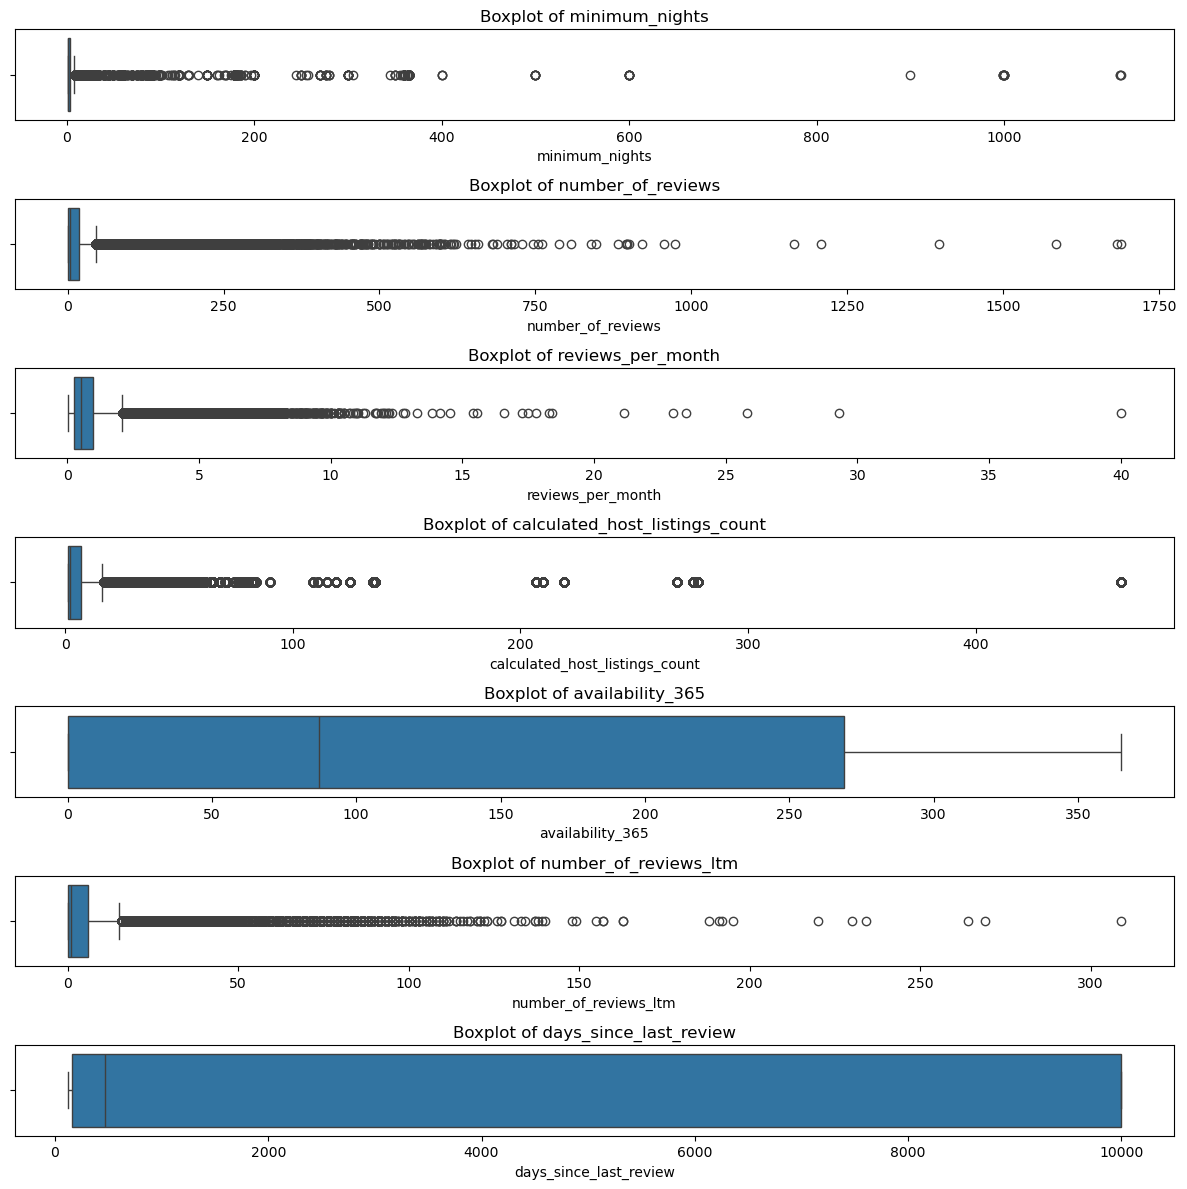

In [29]:
numeric_columns = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                        'calculated_host_listings_count', 'availability_365', 
                        'number_of_reviews_ltm','days_since_last_review'] # Define a list of numeric columns to explore for outliers
skew_values = airbnb[numeric_columns].skew() # Calculate and print skewness values for selected columns
print("The skewness of numerical varibles:\n", skew_values)
plt.figure(figsize=(12, 12)) # Create a boxplot for each numeric variable to explore outliers
for i, col in enumerate(numeric_columns, 1):  # Create a subplot for each variable
    plt.subplot(len(numeric_columns), 1, i) 
    sns.boxplot(x=airbnb[col])  
    plt.title(f'Boxplot of {col}')  #
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

The columns <b> 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'number_of_reviews_ltm', and 'days_since_last_review' </b> have many outliers and strong skewness, and will be transformed using the <b> IQR </b>.  Also, the 'minimum_nights' variable will be cleaned by removing values greater than or equal to 365 nights (1 year), as such values seem to be not realistic. 

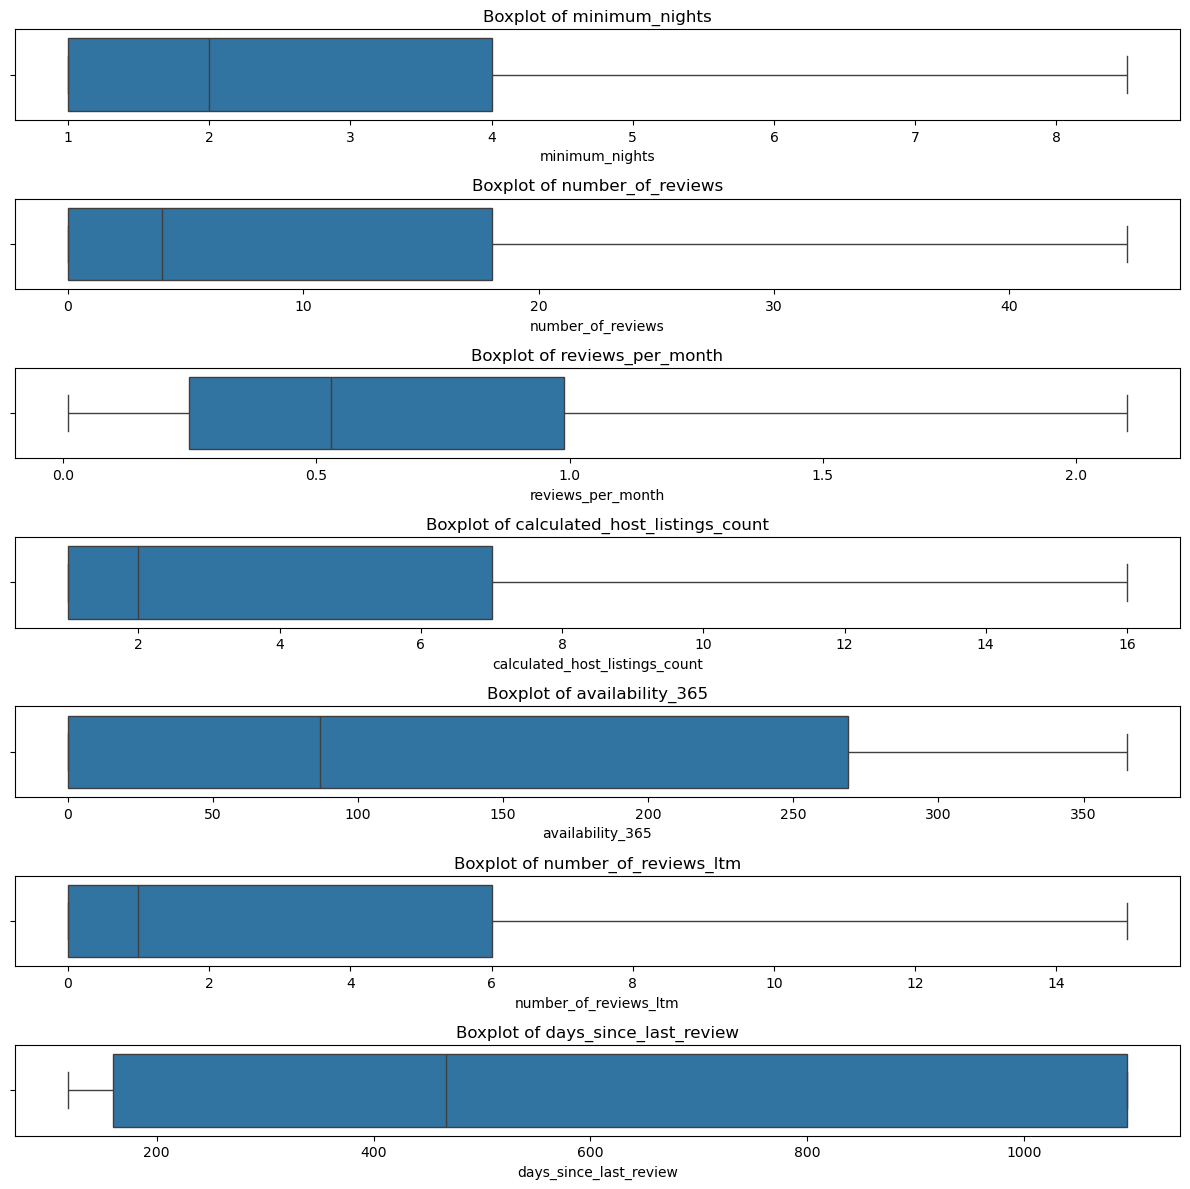

The skewness after capping:
 minimum_nights                    1.285227
number_of_reviews                 1.212586
reviews_per_month                 1.092458
calculated_host_listings_count    1.213762
availability_365                  0.482360
number_of_reviews_ltm             1.239642
days_since_last_review            0.111405
dtype: float64


In [31]:
airbnb = airbnb.loc[airbnb['minimum_nights'] <= 365] # Remove rows where 'minimum_nights' is greater than 365

columns_to_cap = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'number_of_reviews_ltm'] # Define the columns
# Loop to apply IQR
for col in columns_to_cap:
    Q1 = airbnb[col].quantile(0.25)
    Q3 = airbnb[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    airbnb[col] = airbnb[col].clip(lower=lower_bound, upper=upper_bound)

airbnb['days_since_last_review'] = airbnb['days_since_last_review'].clip(upper=1095) # Cap 'days_since_last_review' at 1095 (3 years)

numeric_columns = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',  # Define the numeric columns for boxplot visualization
                   'calculated_host_listings_count', 'availability_365', 
                   'number_of_reviews_ltm', 'days_since_last_review']

plt.figure(figsize=(12, 12)) # Plot boxplots to visualize the effect of capping
for i, col in enumerate(numeric_columns, 1): 
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(x=airbnb[col])  
    plt.title(f'Boxplot of {col}') 
plt.tight_layout()
plt.show()

skew_values = airbnb[numeric_columns].skew() # Calculate and print skewness values after transformation
print("The skewness after capping:\n", skew_values)

After applying IQR capping transformation, the skewness has been reduced, and the boxplots don't display any outliers, indicating that the data is now closer to a normal distribution.

In [34]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95114 entries, 0 to 95143
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              95114 non-null  int64  
 1   name                            95114 non-null  object 
 2   host_id                         95114 non-null  int64  
 3   host_name                       95114 non-null  object 
 4   neighbourhood                   95114 non-null  object 
 5   latitude                        95114 non-null  float64
 6   longitude                       95114 non-null  float64
 7   room_type                       95114 non-null  object 
 8   price                           95114 non-null  float64
 9   minimum_nights                  95114 non-null  float64
 10  number_of_reviews               95114 non-null  int64  
 11  reviews_per_month               95114 non-null  float64
 12  calculated_host_listings_count  95114

### Feature Engineering

For the modeling, additional features will be created:
<ul>
<li> <b> the average price per neighbourhood </b>; </li> 
<li> <b>the average price per room type</b>; </li>
<li> <b>the ratio of reviews to availability</b> (how often listings receive reviews relative to their open days); </li>
<li> <b>distance to the city center</b>; </li>
<li> <b>price per review</b> (a higher value indicates a premium or less frequently booked listing, a lower value suggests high demand or affordability); </li>
<li> <b>the ratio of reviews to minimum nights </b> (a higher value indicates high guest turnover, a lower value suggests longer stays with fewer reviews). </li> 
</ul>

In [37]:
neighbourhood_avg_price = airbnb.groupby('neighbourhood')['price'].transform('mean')  # Calculate average price per neighbourhood
airbnb['neighbourhood_avg_price'] = neighbourhood_avg_price 

room_type_avg_price = airbnb.groupby('room_type')['price'].transform('mean')  # Calculate average price per room type
airbnb['room_type_avg_price'] = room_type_avg_price

airbnb['reviews_to_availability'] = airbnb['number_of_reviews'] / (airbnb['availability_365'] + 1)  # Calculate reviews to availability ratio

from geopy.distance import geodesic

center_location = (51.5074, -0.1278)  # Example for London (latitude, longitude)
airbnb['distance_to_center'] = airbnb.apply(lambda row: geodesic(center_location, (row['latitude'], row['longitude'])).km, axis=1)  # Calculate distance from listing to center

airbnb['price_per_review'] = airbnb['price'] / (airbnb['number_of_reviews'] + 1)  # Calculate price per review

airbnb['reviews_to_minimum_nights'] = airbnb['number_of_reviews'] / (airbnb['minimum_nights'] + 1)  # Calculate reviews to minimum nights ratio
# Check for null values in the dataset
airbnb.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
days_since_last_review            0
neighbourhood_avg_price           0
room_type_avg_price               0
reviews_to_availability           0
distance_to_center                0
price_per_review                  0
reviews_to_minimum_nights         0
dtype: int64

### Exploratory Data Analysis

Next, let's illustrate <b> the average prices per neighbourhood</b> and <b>room type </b> after cleaning the data.

C:\Users\tasha\AppData\Local\Temp\ipykernel_11640\2072120129.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='room_type', y='price', data=avg_price_room_type, palette='viridis')


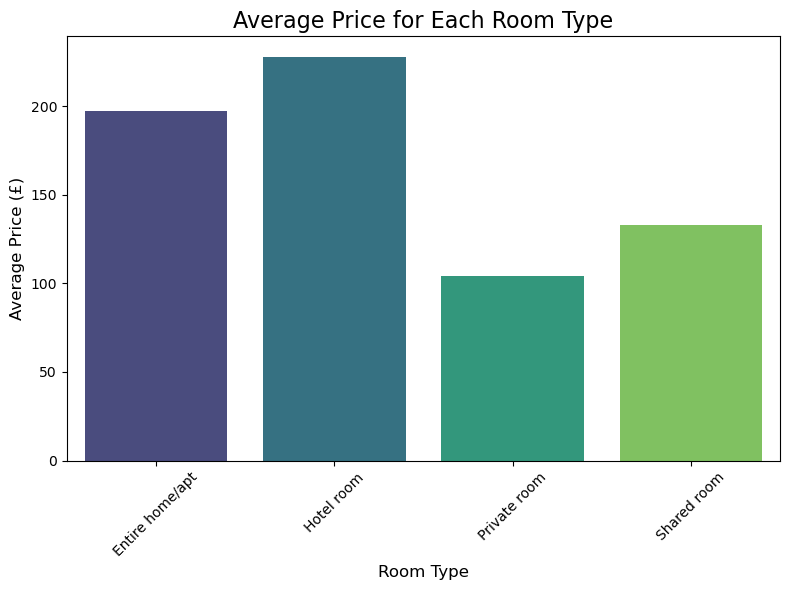

In [43]:
avg_price_room_type = airbnb.groupby('room_type')['price'].mean().reset_index() # Calculate average price for each room type

# Create a bar plot for average price by room type
plt.figure(figsize=(8, 6))
sns.barplot(x='room_type', y='price', data=avg_price_room_type, palette='viridis')

# Add labels and title
plt.title('Average Price for Each Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Average Price (£)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<b> Hotel_room </b> type has the highest average price in London listing - around <b>£220 per night </b>. <b> Private room </b> shows the average price closer to <b> £100 per night </b>.

In [46]:
import folium
import geopandas as gpd

neighborhoods = gpd.read_file("london_boroughs.geojson") # Load the GeoJSON file
neighborhoods = neighborhoods.rename(columns = {"name": "neighbourhood"})
neighborhoods = neighborhoods.set_index("neighbourhood")

airbnb_avg_price = airbnb.groupby("neighbourhood")["price"].mean() # Group Airbnb data by neighbourhood and compute the average price

merged_data = neighborhoods.join(airbnb_avg_price) # Merge datasets
merged_data.reset_index(inplace = True)

choropleth_map = folium.Map(location=[airbnb['latitude'].mean(), airbnb['longitude'].mean()], zoom_start=11) # Create the map

# Add the choropleth layer
folium.Choropleth(
    geo_data = "london_boroughs.geojson",
    name = "choropleth",
    data = merged_data,
    columns = ["neighbourhood", "price"],
    key_on = "feature.properties.name",
    fill_color = "YlOrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Average Airbnb Price by Borough"
).add_to(choropleth_map)

# Label each neighborhood showing the average price
for idx, row in merged_data.iterrows():
    
    # Get the latitude and longitude from the clean_df for the current neighborhood
    neighborhood_lat = airbnb[airbnb['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    neighborhood_lon = airbnb[airbnb['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    price = round(row['price'], 2)  # Round to two decimal places for better readability
    
    # Create a label with neighborhood name and average price
    label = folium.Popup(f"{row['neighbourhood']}: £{price}", parse_html = True)

    # Add the label at the calculated average
    folium.Marker([neighborhood_lat, neighborhood_lon], popup=label).add_to(choropleth_map)
choropleth_map

<b> The central (Kensington and Chelsea, Westminster, City Of London)</b> area appears to be more expensive, with prices ranging <b>£213-£252 </b>  per night. <b> The western, southern, and eastern outskirts </b> of London have a lower average price per neighborhood - <b> from £103 to £128 </b> per night . 

Let's explore <b> guest engagement</b> by visualizing 3 key metrics: <b> the ratio of reviews to availability, the ratio of reviews to minimum nights, and price per review. </b>

In [50]:
avg_reviews_availability = airbnb.groupby('neighbourhood')['reviews_to_availability'].mean()

# Merge datasets
merged_data = neighborhoods.join(avg_reviews_availability)
merged_data.reset_index(inplace = True)

# Create the map
choropleth_map = folium.Map(location = [airbnb['latitude'].mean(), airbnb['longitude'].mean()], zoom_start=11)

# Add the choropleth layer
folium.Choropleth(
    geo_data = "london_boroughs.geojson",
    name = "choropleth",
    data = merged_data,
    columns = ['neighbourhood', 'reviews_to_availability'],
    key_on = "feature.properties.name",
    fill_color = "YlGnBu",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = f"Average {'reviews_to_availability'.replace('_', ' ').title()} by Borough"
).add_to(choropleth_map)

# Label each neighborhood with the average variable value
for idx, row in merged_data.iterrows():
    neighborhood_lat = airbnb[airbnb['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    neighborhood_lon = airbnb[airbnb['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    value = round(row['reviews_to_availability'], 2)

    # Create a label
    label = folium.Popup(f"{row['neighbourhood']}: {value}", parse_html=True)

    # Add the label
    folium.Marker([neighborhood_lat, neighborhood_lon], popup = label).add_to(choropleth_map)

choropleth_map

<b> Lambeth, Southwark, Islington and Hackney</b> have a higher ratio of reviews to availability, suggesting more frequent bookings and higher guest engagement. In contrast, neighborhoods like <b> Barking and Dagenham and Bexley</b> show a lower ratio, indicating less frequent bookings and lower engagement.

In [53]:
avg_price_review = airbnb.groupby('neighbourhood')['price_per_review'].mean()

# Merge datasets
merged_data = neighborhoods.join(avg_price_review)
merged_data.reset_index(inplace = True)

# Create the map
choropleth_map = folium.Map(location=[airbnb['latitude'].mean(), airbnb['longitude'].mean()], zoom_start=11)

# Add the choropleth layer
folium.Choropleth(
    geo_data="london_boroughs.geojson",
    name = "choropleth",
    data = merged_data,
    columns = ['neighbourhood', 'price_per_review'],
    key_on = "feature.properties.name",
    fill_color = "RdYlGn",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = f"Average {'price_per_review'.replace('_', ' ').title()} by Borough"
).add_to(choropleth_map)

# Label each neighborhood with the average variable value
for idx, row in merged_data.iterrows():
    neighborhood_lat = airbnb[airbnb['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    neighborhood_lon = airbnb[airbnb['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    value = round(row['price_per_review'], 2)

    # Create a label
    label = folium.Popup(f"{row['neighbourhood']}: £{value}", parse_html = True)

    # Add the label
    folium.Marker([neighborhood_lat, neighborhood_lon], popup = label).add_to(choropleth_map)

choropleth_map

<b> Kensington and Chelsea </b>, along with <b>Westminster and the City of London</b>, have the highest average price per review, ranging <b>from £86 to £105</b>. This suggests that these areas have more expensive listings but fewer reviews, possibly because the listings are less frequently booked or cater to a more niche, premium audience.

In [56]:
reviews_min_nights = airbnb.groupby('neighbourhood')['reviews_to_minimum_nights'].mean()

# Merge datasets
merged_data = neighborhoods.join(reviews_min_nights)
merged_data.reset_index(inplace = True)

# Create the map
choropleth_map = folium.Map(location=[airbnb['latitude'].mean(), airbnb['longitude'].mean()], zoom_start=11)

# Add the choropleth layer
folium.Choropleth(
    geo_data="london_boroughs.geojson",
    name = "choropleth",
    data = merged_data,
    columns = ['neighbourhood', 'reviews_to_minimum_nights'],
    key_on = "feature.properties.name",
    fill_color = "BuGn",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = f"Average {'reviews_to_minimum_nights'.replace('_', ' ').title()} by Borough"
).add_to(choropleth_map)

# Label each neighborhood with the average variable value
for idx, row in merged_data.iterrows():
    neighborhood_lat = airbnb[airbnb['neighbourhood'] == row['neighbourhood']]['latitude'].mean()
    neighborhood_lon = airbnb[airbnb['neighbourhood'] == row['neighbourhood']]['longitude'].mean()
    value = round(row['reviews_to_minimum_nights'], 2)

    # Create a label
    label = folium.Popup(f"{row['neighbourhood']}: {value}", parse_html=True)

    # Add the label
    folium.Marker([neighborhood_lat, neighborhood_lon], popup=label).add_to(choropleth_map)

choropleth_map

<b> Richmond Upon Thames, Westminster, and Camden </b> display the highest average reviews per minimum night, indicating higher guest turnover relative to the minimum stay requirements. In contrast, <b> the eastern outskirts </b> have the lowest average, suggesting lower guest engagement and less frequent bookings in these areas.

Next, the variables with the strongest correlations to the 'price' column are being identified.

In [60]:
numeric_columns = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 
                        'calculated_host_listings_count', 'availability_365', 
                        'number_of_reviews_ltm','days_since_last_review', 
                   'longitude', 'latitude']
engineered_features = ['reviews_to_availability', 'distance_to_center', 'reviews_to_minimum_nights']
all_features = numeric_columns + engineered_features
correlation_matrix = airbnb[numeric_columns + ['price']].corr() # Calculate the correlation matrix for the selected columns
print(correlation_matrix['price'].sort_values(ascending = False))

price                             1.000000
calculated_host_listings_count    0.213487
availability_365                  0.146078
minimum_nights                    0.071854
days_since_last_review            0.014151
latitude                         -0.009488
number_of_reviews_ltm            -0.041517
reviews_per_month                -0.045898
number_of_reviews                -0.071691
longitude                        -0.080956
Name: price, dtype: float64


#### Positive correlations:
<ul>
    <li> calculated_host_listings_count (0.213) have the strongest positive correlations with price; </li>
    <li> availability_365 (0.146) also shows moderate positive correlation. </li>
</ul>

#### Negative correlations:
<ul>
    <li> The strongest negative correlation is with distance_to_center (-0.243), indicating that the greater the distance from the center, the lower the price; </li>
    <li> reviews_to_minimum_nights (0.087) shows moderate negative correlation. </li>
</ul>

### Modeling

After testing multiple modeling algorithms, <b> Random Forest Regressor </b> proved to be the most suitable for this dataset based on its superior results.

In [67]:
from sklearn.ensemble import RandomForestRegressor
engineered_selected = ['reviews_to_availability', 'distance_to_center', 'reviews_to_minimum_nights', 
                       'room_type_avg_price', 'neighbourhood_avg_price', 'price_per_review']
columns_for_model = numeric_columns + engineered_selected
x = airbnb[columns_for_model] # Features (x) and target (y)
y = airbnb['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28) # Train-test split

# Our forest consists of 100 trees with a max depth of 5
Random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 5)
Random_forest.fit(x_train,y_train)

RandomForestRegressor(max_depth=5)

In [69]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
y_pred_train = Random_forest.predict(x_train)
y_pred_test = Random_forest.predict(x_test)

# Metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Compare Testing and Training Results
results_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'RMSE': [rmse_train, rmse_test],
    'R-squared': [r2_train, r2_test]
})

print(results_df)

  Dataset       RMSE  R-squared
0   Train  82.229570   0.622347
1    Test  79.381909   0.622981


The model explains 62% of price variance (R² ≈ 0.62) with an RMSE of ~£80 on both train and test sets.

Next, we will check the features for any leakage, where a feature might unfairly improve the model’s performance.

In [72]:
numeric_columns = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 
                        'calculated_host_listings_count', 'availability_365', 
                        'number_of_reviews_ltm','days_since_last_review', 
                   'longitude', 'latitude']
engineered_selected = ['neighbourhood_avg_price', 'room_type_avg_price', 'price_per_review', 
                       'reviews_to_availability', 'distance_to_center', 'reviews_to_minimum_nights']
features = numeric_columns + engineered_selected
correlation_matrix = airbnb[features + ['price']].corr() # Calculate the correlation matrix for the selected columns
print(correlation_matrix['price'].sort_values(ascending = False))

price                             1.000000
price_per_review                  0.620145
neighbourhood_avg_price           0.336837
room_type_avg_price               0.335513
calculated_host_listings_count    0.213487
availability_365                  0.146078
minimum_nights                    0.071854
days_since_last_review            0.014151
latitude                         -0.009488
number_of_reviews_ltm            -0.041517
reviews_per_month                -0.045898
number_of_reviews                -0.071691
reviews_to_availability          -0.074264
longitude                        -0.080956
reviews_to_minimum_nights        -0.088683
distance_to_center               -0.242663
Name: price, dtype: float64


We checked the correlations between the features and price and found no strong correlations (close to 1). This means the features are providing unique and useful information for the model. 

In [75]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(Random_forest, x_train, y_train, cv = 5, scoring = 'r2')
print("Cross-Validation R² Scores:", scores)
print("Mean CV R²:", scores.mean())

Cross-Validation R² Scores: [0.59700832 0.6158714  0.62507201 0.62336143 0.64291051]
Mean CV R²: 0.6208447341718172


The cross-validation R² scores range from 0.59 to 0.64, with a mean of ~0.62, confirming that the model performs consistently across different data splits and maintains good generalization.

Next, we will check the feature importance to see which variables have the biggest impact on the model's predictions.

                           Feature  Importance
14                price_per_review    0.679156
12             room_type_avg_price    0.130085
4                 availability_365    0.058875
13         neighbourhood_avg_price    0.054648
1                number_of_reviews    0.029831
11       reviews_to_minimum_nights    0.019026
9          reviews_to_availability    0.018184
6           days_since_last_review    0.008349
10              distance_to_center    0.001744
7                        longitude    0.000044
3   calculated_host_listings_count    0.000019
2                reviews_per_month    0.000014
5            number_of_reviews_ltm    0.000013
8                         latitude    0.000012
0                   minimum_nights    0.000000


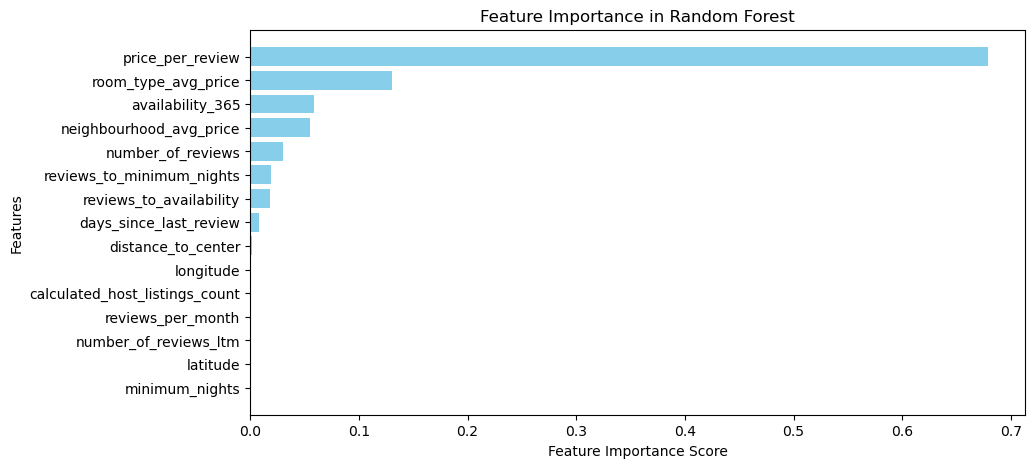

In [78]:
feature_importance = Random_forest.feature_importances_ # Get feature importance values
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importance}) # Create a DataFrame for better visualization
importance_df = importance_df.sort_values(by = 'Importance', ascending = False) # Sort features by importance
print(importance_df) # Print top features

plt.figure(figsize=(10, 5)) # Plot feature importance
plt.barh(importance_df['Feature'], importance_df['Importance'], color = 'skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

The feature importance results show that the most important predictor is <b> price_per_review (0.606)</b>, followed by number_of_reviews (0.181), and room_type_avg_price (0.082).

Since there's no strong correlation <b> above 0.7 </b> and no direct sign of leakage from <b> the price_per_review </b> feature, we can consider it safe to keep it in the model. Also, the performance dropped after removing engineered features indicates that they are indeed adding value to the model, so they may just be important predictors for price.

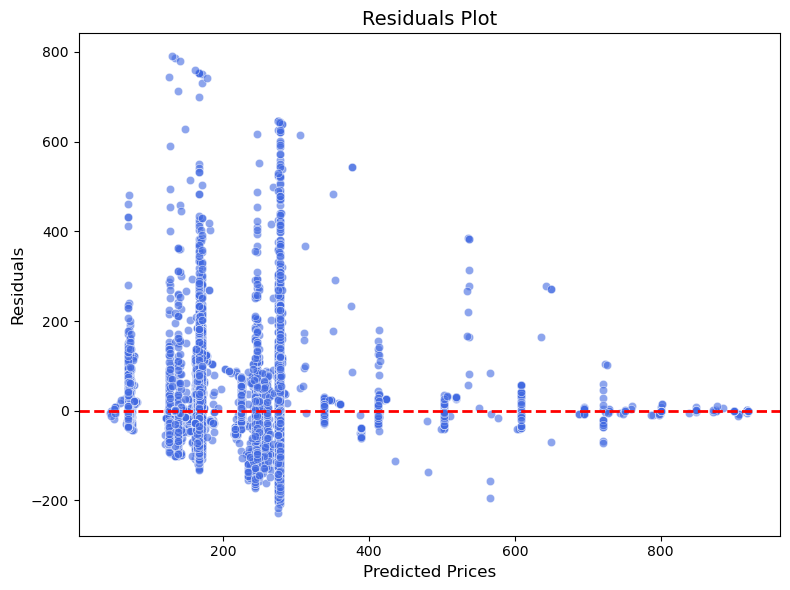

In [82]:
# Calculate residuals (errors)
residuals = y_test - y_pred_test

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.6, color='royalblue')

# Add horizontal line at zero (ideal residual line)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Labels and title
plt.xlabel('Predicted Prices', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residuals Plot', fontsize=14)
plt.tight_layout()
plt.show()

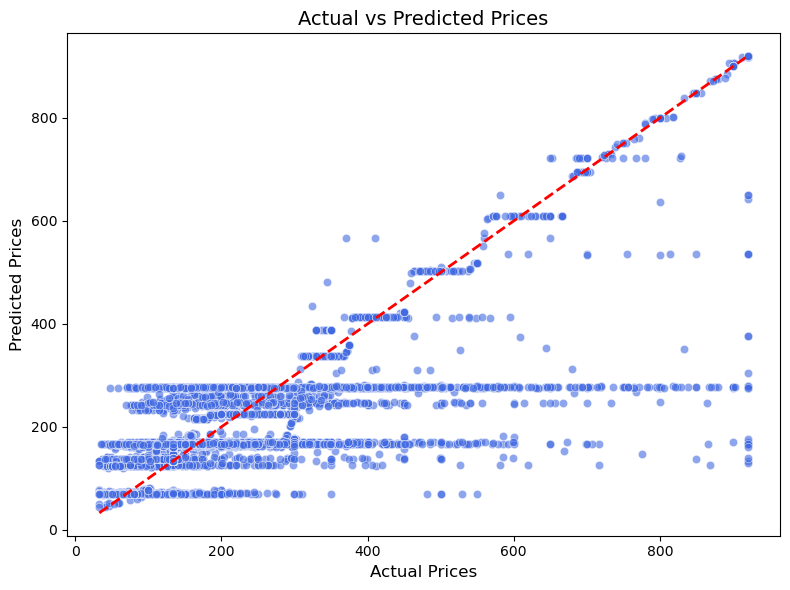

In [84]:
# Plot actual vs predicted prices
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test, y = y_pred_test, alpha = 0.6, color = 'royalblue')

# Add ideal line (where predicted = actual)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red', linestyle = '--', linewidth=2)

# Labels and title
plt.xlabel('Actual Prices', fontsize = 12)
plt.ylabel('Predicted Prices', fontsize = 12)
plt.title('Actual vs Predicted Prices', fontsize = 14)
plt.tight_layout()
plt.show()

Let's predict a price for a new Airbnb listing:

In [87]:
# New listing with values
new_listing = pd.DataFrame({
    'minimum_nights': [3],
    'number_of_reviews': [0],
    'reviews_per_month': [0],
    'calculated_host_listings_count': [2],
    'availability_365': [180],
    'number_of_reviews_ltm': [0],
    'days_since_last_review': [0], 
    'longitude': [-0.359],
    'latitude': [51.587],
    'neighbourhood_avg_price': [109.26],
    'room_type_avg_price': [104.2],
    'reviews_to_availability': [0],
    'distance_to_center': [19.2],
    'price_per_review': [49.18],
    'reviews_to_minimum_nights': [0]
})

# Ensure the new data has the same feature order as x_train
new_listing = new_listing[x_train.columns]

# Predict price using the trained model
predicted_price = Random_forest.predict(new_listing)
print("Predicted Price: £", predicted_price[0])

Predicted Price: £ 69.08445716140695


### Insights

<b> Summary Insights: </b>
<ul>
    <li> <b> Pricing </b>: Hotel rooms average around £220 per night, while Private rooms are closer to £100. Central areas (Kensington, Westminster, City of London) have higher prices (£213 to £252 per night), while the western, southern, and eastern outskirts have lower prices (£103 to £128 per night).</li>
    <li> <b> Guest engagement</b>: Lambeth, Southwark, Islington, and Hackney show higher reviews to availability ratios, indicating more frequent bookings. Areas like Barking and Dagenham and Bexley show lower engagement</li>
    <li> <b> Price per Review</b>: Kensington and Chelsea, Westminster, the City of London have the highest price per review (£86 to £105), suggesting fewer reviews but premium pricing.</li>
    <li> <b> Reviews per Minimum night </b>: Richmond Upon Thames, Westminster, and Camden show higher reviews per minimum night, indicating high guest turnover, while the eastern outskirts have lower values.</li>
    <li> <b> Modeling </b>: The Random Forest model performed well with an R-squared of 62%, RMSE of around £80. The model suggests that 'price_per_review', 'room_type_avg_price' and 'availability_365' are key factors in determining the price of a listing.</li>
</ul>

<b> Recommendations for Airbnb Hosts:</b>
1. <b> Central locations for premium pricing</b>: Hosts in central areas like Kensington, Westminster, and the City of London should focus on premium pricing for hotel rooms, as these areas offer higher prices and attract a more upscale audience;
2. <b> Affordable pricing for Outskirts</b>: Hosts in the western, southern, and eastern outskirts of London should consider pricing their listings more affordably, ranging between £103-£128 per night, to remain competitive. These areas attract more budget guests and may benefit from offering shared or private rooms at lower prices;
3. <b> Increase Guest engagement</b>: Hosts in lower-engagement neighborhoods (e.g., Barking and Dagenham, Bexley) should lower minimum night requirements or introduce special offers to increase bookings and reviews. Lambeth, Southwark, Islington, and Hackney demonstrate that high guest engagement leads to better performance—similar strategies can benefit hosts in less popular areas;
4. <b> Target short-term stays </b>: In neighborhoods like Richmond Upon Thames, Westminster, and Camden, where reviews per minimum night are high, hosts should promote short-term stays and flexible booking options to increase turnover.;
5. <b> Adjust pricing based on reviews</b>: Hosts in high-priced areas (Kensington and Chelsea, Westminster, City of London) should offer premium features or amenities to justify their rates. Hosts in lower-priced areas (Barking and Dagenham, Bexley) should maintain affordable rates to appeal to a broader audience.;
6. <b> Optimize listing distance from the Center </b>: Since distance from the center negatively correlates with price, hosts in outer neighborhoods should highlight unique features, local attractions, or better amenities to justify their pricing and attract more guests;
7. <b> Optimize Listings by Room Type</b>: Since 'room_type_avg_price' is a significant feature, hosts should consider adjusting prices based on the type of room offered. Hotel rooms command higher prices, while private rooms should be priced more affordably;
8. <b>Leverage Reviews</b>: Since 'number_of_reviews' and 'price_per_review' play a large role in price prediction, hosts with fewer reviews should focus on increasing guest engagement and gathering reviews to improve visibility and pricing potential.

In [194]:
airbnb.to_csv("airbnb.csv", index=False)
print("CSV file saved as 'airbnb.csv'")

CSV file saved as 'airbnb.csv'
